# Final Project - Deep RL Learning in MultiRoom Environment

---

Name and ID:  
Student 1: 204266191
<br>
Student 2: 318947470
<br><br>


# Pre-Requisit


## Imports


In [1]:
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pyvirtualdisplay
import IPython
import base64
import gymnasium
import minigrid
from minigrid.wrappers import RGBImgObsWrapper, RGBImgPartialObsWrapper, ImgObsWrapper, FullyObsWrapper, RGBImgPartialObsWrapper
import matplotlib.pyplot as plt
import imageio
import numpy as np
import cv2
print("Global dependencies loaded successfully")

Global dependencies loaded successfully


In [ ]:
# our project imports
from minigrid.envs import MultiRoomEnv
import gymnasium as gym
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
import os
import tqdm
from cv2 import cvtColor
from pathlib import Path
from abc import ABC, abstractmethod
from typing import Tuple, List, Deque 
import importlib
import time

print("Local dependencies loaded successfully")


ImportError: cannot import name 'String' from 'typing' (c:\Users\ASUS\anaconda3\envs\minigrid-rl\lib\typing.py)

In [3]:
from display_functions import show_full_frame_rgb, show_partial_greyscale, show_state_full_and_partial, plot_training_process
from env_functions import create_multiroom_env, get_action_meaning

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

cuda_available = torch.cuda.is_available()
print(f"CUDA Available: {cuda_available}")

if cuda_available:
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Device Count: {torch.cuda.device_count()}")

CUDA Available: True
CUDA Device: NVIDIA GeForce RTX 4050 Laptop GPU
CUDA Device Count: 1


In [5]:
# Constants for the environemnt configuration do no change the values
highlight = False
render_mode = "rgb_array"
WORK_DIR = Path("C:/Users/ASUS/OneDrive/MSc MLDS/Reinforcement Learning/Projects/final-project")
ACTIONS_SPACES = [0, 1, 2, 5]
ACTIONS_SPACES_MAPPED = {0: 0, 1: 1, 2: 2, 5: 3}  
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## Display Functions

The cell below contains the video display configuration. No need to make changes here.


In [6]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

# display = pyvirtualdisplay.Display(visible=0, size=(1400, 900), backend=None).start()

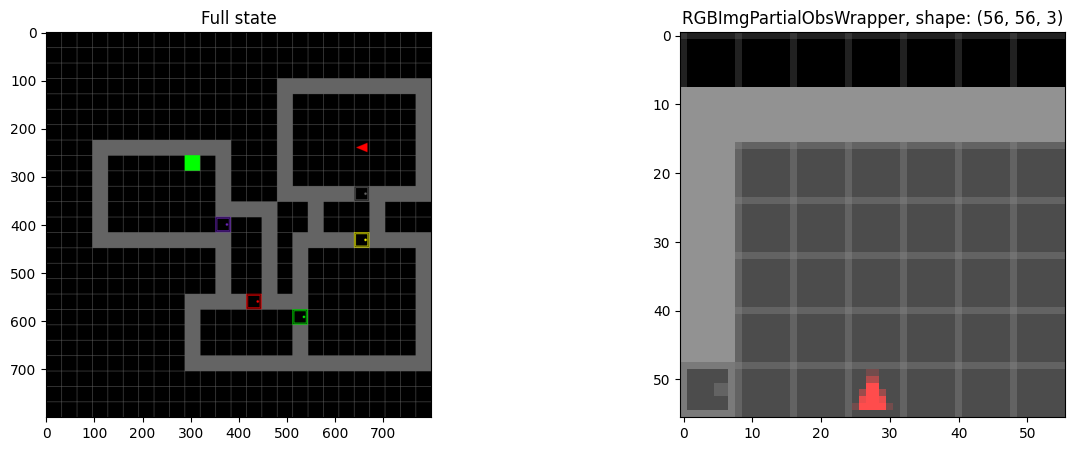

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
env = gymnasium.make("MiniGrid-MultiRoom-N6-v0", render_mode=render_mode, highlight=highlight)
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)
obs, _ = env.reset()
axs[1].imshow(obs)
axs[1].title.set_text(f'RGBImgPartialObsWrapper, shape: {obs.shape}')
axs[0].imshow(env.render())
axs[0].title.set_text(f'Full state')
plt.show()

## Initializing the smaller environments


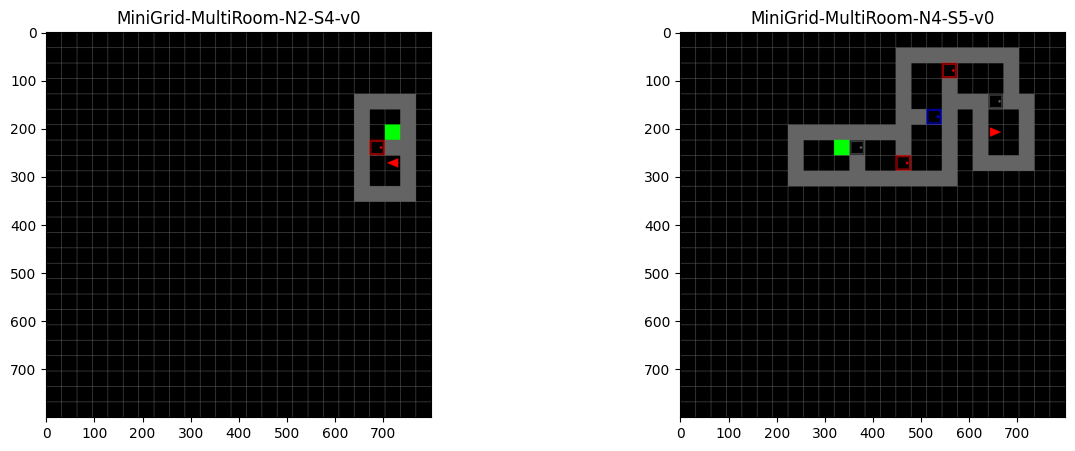

In [8]:
env = gymnasium.make("MiniGrid-MultiRoom-N2-S4-v0", render_mode=render_mode, highlight=highlight)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)
obs, _ = env.reset()
axs[0].imshow(env.render())
axs[0].title.set_text(f'MiniGrid-MultiRoom-N2-S4-v0')



env = gymnasium.make("MiniGrid-MultiRoom-N4-S5-v0", render_mode=render_mode, highlight=highlight)
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)
obs, _ = env.reset()
axs[1].imshow(env.render())
axs[1].title.set_text(f'MiniGrid-MultiRoom-N4-S5-v0')
plt.show()

### Partial Observation Example


In [9]:
env = gymnasium.make("MiniGrid-MultiRoom-N6-v0", render_mode=render_mode, highlight=highlight)
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)
# video_filename = '/content/vid_partial.mp4'
video_filename = "C:/Users/ASUS/OneDrive/MSc MLDS/Reinforcement Learning/Projects/final-project/videos/fdfdfdfdfdf.mp4"
truncated = False
# Evaluation
with imageio.get_writer(video_filename, fps=10) as video:
  obs, _ = env.reset()
  done = False
  total_reward = 0
  step = 0
  while not truncated:
      action = env.action_space.sample()
      obs, reward, done, truncated  , _ = env.step(action)
      next_obs = obs  # Get agent's position directly from the environment
      video.append_data(obs)
      step += 1
      if truncated:
        print("done","reward=", total_reward,"num_of_steps=",step)
        break
# embed_mp4(video_filename)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (56, 56) to (64, 64) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


done reward= 0 num_of_steps= 120


# Our Code


## Auxiliary Functions


### Environment Functions

For better controll over randomization and the learning process, we will implement the create_multiroom_env function that allows us to create environments with any number of rooms of any size. It will help us to do the learning gradually. the get_action_meaning function will help use to make out put more readable.


### Display Functions

For advanced debugging purpose we implemented functions that allows us to visualize sequence of frames, compitalbe with MultiRoom API. In additin we implement render_agent_video for visualizing a give agent in a give environment.


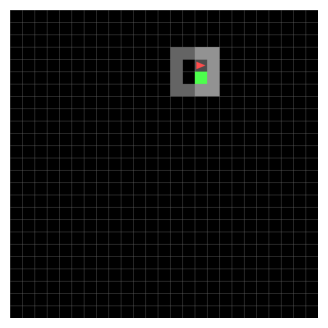

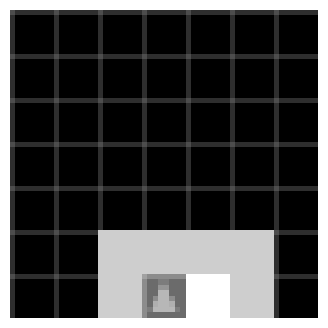

In [10]:
from display_functions import show_full_frame_rgb, show_partial_greyscale, render_agent_video, show_state_full_and_partial
env, obs = create_multiroom_env(1, 4)
img_rgb = show_full_frame_rgb(env, obs)
img_grey = show_partial_greyscale(env, obs)

--------------------------------------------------
Step 0
Action taken: 0 (Move Left)


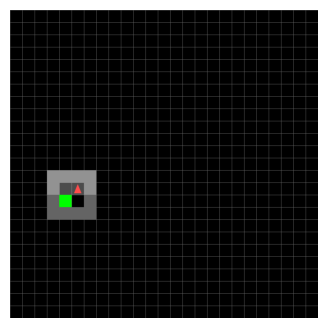

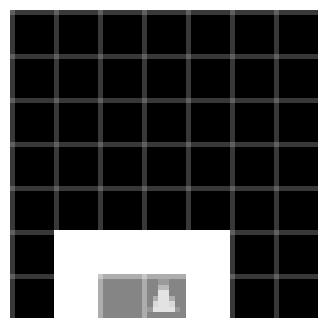

--------------------------------------------------
Step 1
Action taken: 2 (Move Forward)


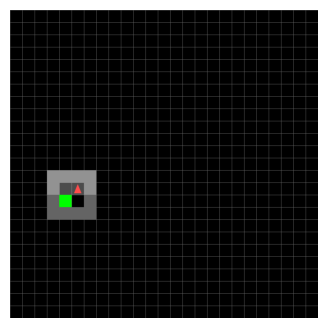

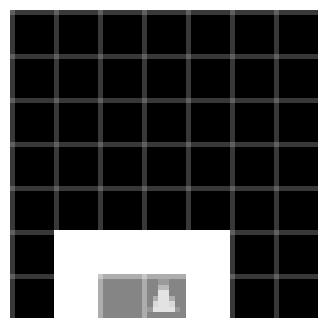

--------------------------------------------------
Step 2
Action taken: 0 (Move Left)


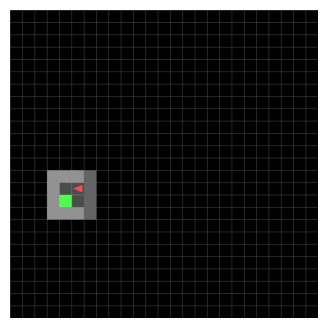

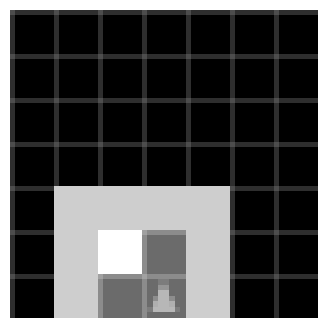

In [11]:
def show_N_steps(env, N, policy=None):
    """
    Runs N steps in the environment, rendering each step.

    Parameters:
        env: The environment instance.
        N (int): Number of steps to execute.
        policy (function): Function that takes obs and returns an action. Defaults to random.
    """
    if policy is None:
        policy = lambda obs: random.choice(ACTIONS_SPACES)  # Default to random actions

    obs, _ = env.reset()  # Ensure the environment starts correctly

    for i in range(N):
        print("--------------------------------------------------")
        print(f"Step {i}")

        action = policy(obs)  # Get action from policy
        print(f"Action taken: {action} ({get_action_meaning(action)})")
        obs, reward, done, truncated, info = env.step(action)

        show_full_frame_rgb(env, obs)
        show_partial_greyscale(env, obs)



        if done or truncated:  # Reset if the episode ends
            print("Environment reset!")
            obs, _ = env.reset()
env
# verification
show_N_steps(env, 3)


### Preprocess Class

Environments like MiniGrid MultiRoom require the agent to understand spatial dependencies and remember past observations to make optimal decisions. However, standard observations only provide a single frame, making it difficult for the agent to infer motion, detect doors opening, or track past locations. In order to deal with this, especially to encourage the agent to learn the process of open door and moving to the next room, we will implement FrameStackPreprocess. In addition, this class will convert the observation to greyscale becasue the RGB channels doesn't contribute to the learning process and do downsampling to better efficency and generalization (we don't need the fine details of the environment).


In [12]:
class FrameStackPreprocess:
    """
    A wrapper for preprocessing and stacking consecutive frames into different channels.
    - Converts RGB frames to grayscale.
    - Normalizes pixel values.
    - Optionally downsamples to a target size.
    - Stacks the last N frames to capture temporal information.

    Parameters:
        num_frames (int): Number of frames to stack.
        img_size (tuple): Original (Height, Width) of frames.
        downsample_size (tuple): Target (Height, Width) after downsampling.
    """

    def __init__(self, num_frames=3, img_size=(56, 56), downsample_size=(14, 14)):
        self.num_frames = num_frames
        self.frames = deque(maxlen=num_frames)  # Store last N frames
        self.img_size = img_size  # Ensure all frames have the same shape
        self.downsample_size = downsample_size  # Target downsampling resolution

    def _convert_to_grayscale(self, frame):
        """Converts an RGB frame to grayscale and normalizes it."""
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
        # frame_gray = frame_gray.astype(np.float32) / 255.0  # Normalize pixel values
        return frame_gray  # Shape: (H, W)

    def _downsample(self, frame):
        """Resizes the frame to the target downsampling size."""
        return cv2.resize(frame, self.downsample_size, interpolation=cv2.INTER_AREA)

    def preprocess(self, frame):
        """Applies grayscale conversion and downsampling."""
        gray_frame = self._convert_to_grayscale(frame)
        return self._downsample(gray_frame)

    def reset(self, first_frame):
        """Initialize the frame stack with copies of the first preprocessed frame."""
        processed_frame = self.preprocess(first_frame)
        for _ in range(self.num_frames):
            self.frames.append(processed_frame)
        return np.stack(self.frames, axis=0)  # Shape: (num_frames, H, W)

    def update(self, new_frame):
        """Add a new frame to the stack and remove the oldest."""
        processed_frame = self.preprocess(new_frame)
        self.frames.append(processed_frame)
        return np.stack(self.frames, axis=0)  # Shape: (num_frames, H, W)
    
    def get_stack(self):
      return torch.tensor(self.frames)


env, obs = create_multiroom_env(1, 50)
frame_stack=FrameStackPreprocess()
frame_stack.reset(obs)
frame_stack.get_stack().shape

C:\Users\ASUS\AppData\Local\Temp\ipykernel_17224\3882089444.py:50: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  return torch.tensor(self.frames)


torch.Size([3, 14, 14])

#### Test FrameStackPreprocess Class

To make sure that this fundemental class has no bug and doesn't miss crucial information for learning, we will explicitly check how the stack looks in every state in this simple environment when acting allways forward" with 1 big room with the reward in the other side.


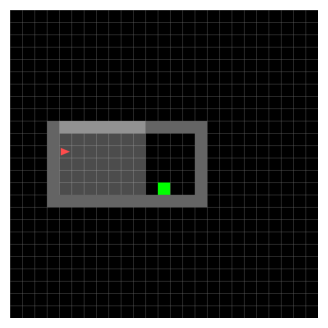

In [13]:
from display_functions import show_full_frame_rgb
env, obs = create_multiroom_env(1, 50, seed=333)
show_full_frame_rgb(env, obs)

Let's have a look on the stack in the 7 first step focusing on the deque mechanism:


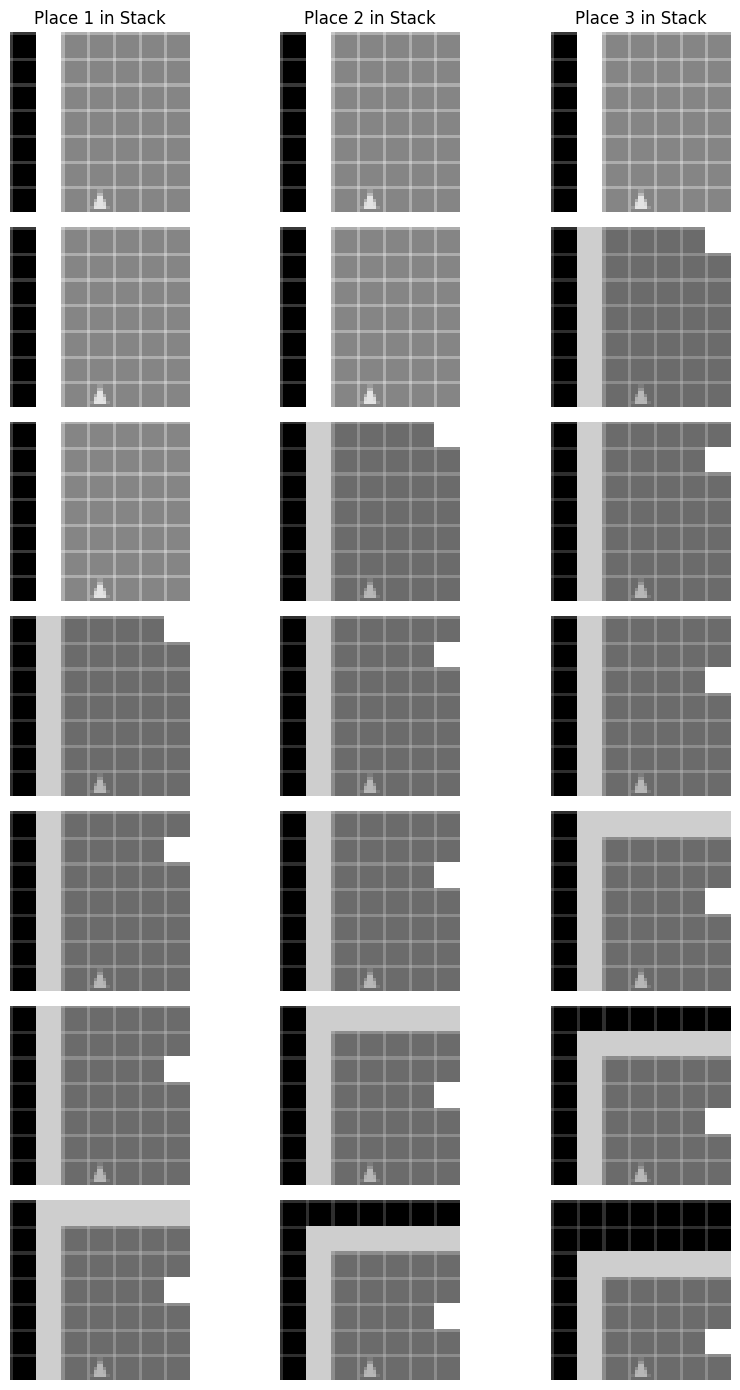

In [14]:
env, obs = create_multiroom_env(1, 50, seed=333)
frame_stack = FrameStackPreprocess(downsample_size=(56, 56))
frame_stack.reset(obs)
frame_stack.get_stack().shape

action = 2 # Always move forward

import matplotlib.pyplot as plt

def visualize_frame_stack(env, preprocessor, policy, N=7):
    """
    Runs N iterations, updates FrameStackPreprocess, and directly plots stack positions.

    Parameters:
        env: The MiniGrid environment (already initialized).
        preprocessor: Instance of FrameStackPreprocess.
        policy: Function that returns the action to take.
        N: Number of iterations.

    Returns:
        None (displays plots).
    """
    fig, axes = plt.subplots(N, 3, figsize=(9, 2 * N))  # N rows, 3 columns

    for i in range(N):
        action = policy(env)  # Get action from policy
        obs, _, _, _, _ = env.step(action)  # Step in environment
        stacked_frames = preprocessor.update(obs)  # Update the stack

        for j in range(3):  # 3 stacked frames
            axes[i, j].imshow(stacked_frames[j], cmap="gray")
            axes[i, j].axis("off")
            if i == 0:
                axes[i, j].set_title(f"Place {j+1} in Stack")

    plt.tight_layout()
    plt.show()


visualize_frame_stack(env, frame_stack, lambda env: 2)

As we can see, the stack work well, the transformation of the image still allows to distinct between the tiles of wall, open tile, doors and goal.
Now lets check the downsampling mechanism to reduce resolution for more efficent learning and better visualiztion:


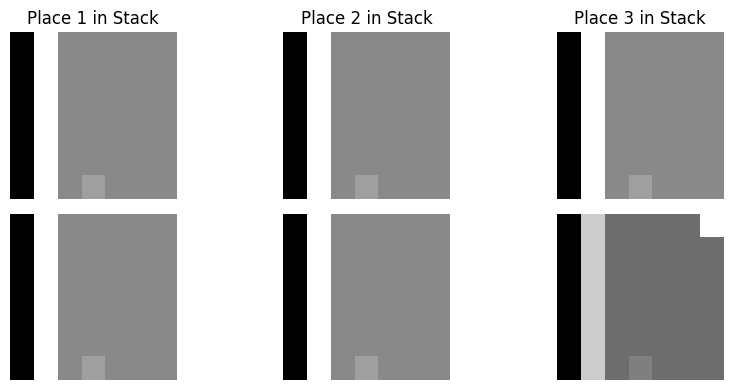

In [15]:
env, obs = create_multiroom_env(1, 50, seed=333)
frame_stack = FrameStackPreprocess(downsample_size=(7, 7))
frame_stack.reset(obs)
frame_stack.get_stack().shape
visualize_frame_stack(env, frame_stack, lambda env: 2, N=2)

## Implementing DQN


### QNet Class


In [16]:
class QNet(nn.Module):
    """
    Q-Network model for our RL task - the NN component for DQN, DDQN and Dueling DQN Agents.
    
    This network consists of:
    - Convolutional layers for feature extraction.
    - Fully connected layers for action selection.
    
    Args:
        input_size (Tuple[int, int, int]): Tuple representing (channels, height, width) of input.
        num_actions (int): Number of possible actions in the environment.

    Example:
        >>> model = DQN((4, 84, 84), num_actions=6)
        >>> x = torch.randn(1, 4, 84, 84)  # Batch of one sample
        >>> output = model(x)
        >>> print(output.shape)  # Expected: (1, 6)
    """

    def __init__(self, input_size: Tuple[int, int, int], num_actions: int, device) -> None:
        super().__init__()
        # define the device of self (the model)
        self.device = device

        # Extract input dimensions
        c, h, w = input_size  # (number of frames, height, width)

        # Convolutional layers for feature extraction
        self.conv = nn.Sequential(
            nn.Conv2d(c, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        ).to(self.device)

        # Compute the flattened size after convolutions
        conv_out_size = self._get_conv_size((c, h, w))

        # Fully connected layers for decision making
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 256),
            nn.ReLU(),
            nn.Linear(256, num_actions)
        )

        # Move model to DEVICE after initializing layers
        self.to(self.device)



    def _get_conv_size(self, shape: Tuple[int, int, int]) -> int:
        """
        Computes the flattened size of the feature maps after convolutional layers.

        Args:
            shape (Tuple[int, int, int]): Input shape (channels, height, width).

        Returns:
            int: Number of elements after flattening.
        """
        with torch.no_grad():
            dummy_tensor = self.conv(torch.zeros(1, *shape, device=self.device))  # Pass a dummy tensor
            return dummy_tensor.numel()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, channels, height, width).

        Returns:
            torch.Tensor: Output Q-values for each action, shape (batch_size, num_actions).
        """
        x = x.to(self.device)  # Move input tensor to GPU
        x = self.conv(x)  # Apply convolutional layers
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)  # Apply fully connected layers
        return x



#### Test Qnet


In [17]:

print(DEVICE)
# Define input size and action space
input_size = (4, 10, 10)  # (channels, height, width) - example
num_actions = 5  # Example number of actions

# Initialize model
model = QNet(input_size, num_actions, DEVICE).to(DEVICE)

# Generate a test input (batch_size=1)
test_input = torch.ones(1, *input_size).to(DEVICE)  # All ones, should produce deterministic output

# Forward pass
output = model(test_input)

# Print output
print(f"Output shape: {output.shape}")  # Should be (1, num_actions)
print(f"Output values: {output.cpu().detach().numpy()}")  # Move to CPU before converting to NumPy


cuda
Output shape: torch.Size([1, 5])
Output values: [[-0.06932519  0.02331991 -0.01910738 -0.02867319  0.01901444]]


In [18]:
import torch.optim as optim
# Define loss function and optimizer
criterion = nn.SmoothL1Loss().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Generate a single data point
x = torch.ones(1, *input_size).to(DEVICE) 
y_target = torch.zeros(1, num_actions).to(DEVICE)

# Training loop (few iterations)
for i in range(100):
    optimizer.zero_grad()
    y_pred = model(x)
    loss = criterion(y_pred, y_target)
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
        print(f"Iteration {i}: Loss = {loss.item()}")

# Final check: Should decrease if network works
print("Final loss:", loss.item())


Iteration 0: Loss = 0.0006898593273945153
Iteration 10: Loss = 0.003071616170927882
Iteration 20: Loss = 4.6294608182506636e-05
Iteration 30: Loss = 5.987998065393185e-06
Iteration 40: Loss = 1.4000569308336708e-06
Iteration 50: Loss = 4.711975805093971e-07
Iteration 60: Loss = 1.5363504246579396e-07
Iteration 70: Loss = 4.1390268989971446e-08
Iteration 80: Loss = 4.0973688442136336e-08
Iteration 90: Loss = 1.0624449764407018e-08
Final loss: 2.9228897080457727e-09


In [19]:
# Get initial parameters
initial_weights = {name: param.clone() for name, param in model.named_parameters()}

# Perform one training step
optimizer.zero_grad()
y_pred = model(x)
loss = criterion(y_pred, y_target)
loss.backward()
optimizer.step()

# Check if any parameters changed
for name, param in model.named_parameters():
    if torch.equal(param, initial_weights[name]):
        print(f"Warning: {name} did not update!")
    else:
        print(f"Parameter {name} updated correctly.")


Parameter conv.0.weight updated correctly.
Parameter conv.0.bias updated correctly.
Parameter conv.2.weight updated correctly.
Parameter conv.2.bias updated correctly.
Parameter fc.0.weight updated correctly.
Parameter fc.0.bias updated correctly.
Parameter fc.2.weight updated correctly.
Parameter fc.2.bias updated correctly.


### Replay Buffer Class


In [ ]:
import numpy as np
import random
import torch
from collections import deque
from typing import Tuple, List, Deque

class ReplayBuffer:
    """
    A replay buffer for storing and sampling experiences for agents using Q nets.

    This buffer:
    - Stores experiences as (stacked_state, action, reward, stacked_next_state, done).
    - Maintains a deque for storing the last `buffer_size` experiences.
    - Samples complete frame stacks (not individual frames).
    - Provides batch sampling for training deep Q-networks.
    - Do efficent memory management 

    Args:
        buffer_size (int): Maximum number of experiences to store.
        batch_size (int): Number of samples to retrieve per batch.
        buffer_device (str): the device that the whole buffer is saved on.
        batch_device (str): the device that the sampled batch are moved to.
        

    Example Usage:
        >>> buffer = ReplayBuffer(buffer_size=10000, batch_size=32)
        >>> buffer.add(stacked_state, action, reward, stacked_next_state, done)
        >>> batch = buffer.sample()
    """

    def __init__(self, buffer_size: int, batch_size: int, buffer_device: str, batch_device: str ) -> None:
        self.buffer_device = buffer_device
        self.batch_device = batch_device
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.memory: Deque[Tuple[np.ndarray, int, float, np.ndarray, bool]] = deque(maxlen=buffer_size) # (state, action, reward, next_state, done)

    def add(self, stacked_state: np.ndarray, action: int, reward: float, stacked_next_state: np.ndarray, done: bool) -> None:
        """
        Adds a new experience to the replay buffer - Deque data structure dealls with deleting the old

        Args:
            stacked_state (np.ndarray): Stacked state of shape (num_frames, H, W).
            action (int): Action taken.
            reward (float): Reward received.
            stacked_next_state (np.ndarray): Next stacked state of shape (num_frames, H, W).
            done (bool): Whether the episode ended.
        """
        self.memory.append((stacked_state, action, reward, stacked_next_state, done))
        if self.__len__() > self.buffer_size:
            print("Enough in buffer to sample")

    
    def sample(self) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """ Samples a batch of experiences from the replay buffer """

        if len(self.memory) < self.batch_size:
            raise ValueError("Not enough samples in the buffer to draw a batch.")

        batch = random.sample(self.memory, self.batch_size)

        states, actions, rewards, next_states, dones = zip(*batch)

        try:
            states_tensor = torch.tensor(np.array(states), dtype=torch.float32)
            actions_tensor = torch.tensor(actions, dtype=torch.int64)
            rewards_tensor = torch.tensor(rewards, dtype=torch.float32)
            next_states_tensor = torch.tensor(np.array(next_states), dtype=torch.float32)
            dones_tensor = torch.tensor(dones, dtype=torch.float32)

            return states_tensor, actions_tensor, rewards_tensor, next_states_tensor, dones_tensor
        except Exception as e:
            print("Error during tensor conversion:", e)
            print("Problematic states shape:", np.array(states, dtype=object).shape)
            print("Problematic next_states shape:", np.array(next_states, dtype=object).shape)
            raise e

    def __len__(self) -> int:
        """
        Returns the current size of the replay buffer.

        Returns:
            int: Number of experiences stored.
        """
        return len(self.memory)


In [ ]:
class ReplayBuffer:
    """
    A replay buffer for storing and sampling experiences for agents using Q nets.

    This buffer:
    - Stores experiences as (stacked_state, action, reward, stacked_next_state, done).
    - Maintains a deque for storing the last `buffer_size` experiences.
    - Samples complete frame stacks (not individual frames).
    - Provides batch sampling for training deep Q-networks.
    - Efficient memory management with separate buffer and batch devices.

    Args:
        buffer_size (int): Maximum number of experiences to store.
        batch_size (int): Number of samples to retrieve per batch.
        buffer_device (str): The device on which the replay buffer is stored (typically "cpu").
        batch_device (str): The device to which sampled batches are moved (e.g., "cuda" for GPU training).
    """

    def __init__(self, buffer_size: int, batch_size: int, buffer_device: str = "cpu", batch_device: str = "cuda") -> None:
        self.buffer_device = torch.device(buffer_device)  # Allow user to specify buffer storage device
        self.batch_device = torch.device(batch_device)  # Target device for training
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.memory: Deque[Tuple[np.ndarray, int, float, np.ndarray, bool]] = deque(maxlen=buffer_size)  # (state, action, reward, next_state, done)

    def add(self, stacked_state: np.ndarray, action: int, reward: float, stacked_next_state: np.ndarray, done: bool) -> None:
        """
        Adds a new experience to the replay buffer.

        Args:
            stacked_state (np.ndarray): Stacked state of shape (num_frames, H, W).
            action (int): Action taken.
            reward (float): Reward received.
            stacked_next_state (np.ndarray): Next stacked state of shape (num_frames, H, W).
            done (bool): Whether the episode ended.
        """
        self.memory.append((stacked_state, action, reward, stacked_next_state, done))
    
    def sample(self) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """Samples a batch from the replay buffer and moves it to the batch device for training."""

        if len(self.memory) < self.batch_size:
            raise ValueError("Not enough samples in the buffer to draw a batch.")

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Efficient NumPy conversion (keeps data on buffer_device)
        states_np = np.array(states, dtype=np.float32)
        next_states_np = np.array(next_states, dtype=np.float32)
        actions_np = np.array(actions, dtype=np.int64)
        rewards_np = np.array(rewards, dtype=np.float32)
        dones_np = np.array(dones, dtype=np.float32)

        # Convert to PyTorch tensors and move to batch_device in one step
        states_tensor = torch.from_numpy(states_np).to(self.batch_device)
        next_states_tensor = torch.from_numpy(next_states_np).to(self.batch_device)
        actions_tensor = torch.from_numpy(actions_np).to(self.batch_device)
        rewards_tensor = torch.from_numpy(rewards_np).to(self.batch_device)
        dones_tensor = torch.from_numpy(dones_np).to(self.batch_device)

        return states_tensor, actions_tensor, rewards_tensor, next_states_tensor, dones_tensor

    def __len__(self) -> int:
        """Returns the current size of the replay buffer."""
        return len(self.memory)


#### Test ReplayBuffer


In [29]:
import numpy as np
import torch

# Define buffer parameters
buffer_size = 1000
batch_size = 5
num_frames = 3  # Stack 3 frames per state
height, width = 56, 56  # Frame resolution
downsample_dim = (7,7) # Downsample frames to 7x7 because this is what the agent see

# Initialize FrameStackPreprocess and ReplayBuffer
frame_stack = FrameStackPreprocess(num_frames=num_frames,
                                   img_size=(height, width),
                                   downsample_size=downsample_dim)
buffer = ReplayBuffer(buffer_size=buffer_size,
                      batch_size=batch_size)

# Create a dummy environment-like frame (random grayscale image)
def generate_fake_frame():
    return np.random.randint(0, 256, (height, width, 3), dtype=np.uint8)  # Simulating an RGB frame

# Fill the buffer with experiences
print("Filling Replay Buffer with sample experiences...")

for i in range(100):  # Add 100 experiences
    frame = generate_fake_frame()
    if i == 0:
        stacked_state = frame_stack.reset(frame)  # Initialize stacked frames
    else:
        stacked_state = frame_stack.update(frame)  # Update frame stack

    action = np.random.choice(ACTIONS_SPACES)  # Random action 
    reward = np.random.uniform(-1, 1)  # Random reward
    done = np.random.choice([True, False], p=[0.1, 0.9])  # Random termination flag 

    # Generate the next state
    next_frame = generate_fake_frame()
    stacked_next_state = frame_stack.update(next_frame)

    # Store experience
    buffer.add(stacked_state, action, reward, stacked_next_state, done)

# Check buffer length
print(f"Replay Buffer filled. Current size: {len(buffer)}")

# Sample a batch
print("\nSampling from Replay Buffer...")
states, actions, rewards, next_states, dones = buffer.sample()

# **Verification Tests**
print("\nVerifying sampled data...")

# 1. Check Tensor shapes
assert states.shape == (batch_size, num_frames, downsample_dim[0], downsample_dim[1]), f"Expected states shape {(batch_size, num_frames, downsample_dim[0], downsample_dim[1])}, got {states.shape}"
assert next_states.shape == (batch_size, num_frames, downsample_dim[0], downsample_dim[1]), f"Expected next_states shape {(batch_size, num_frames, downsample_dim[0], downsample_dim[1])}, got {next_states.shape}"
assert actions.shape == (batch_size,), f"Expected actions shape {(batch_size,)}, got {actions.shape}"
assert rewards.shape == (batch_size,), f"Expected rewards shape {(batch_size,)}, got {rewards.shape}"
assert dones.shape == (batch_size,), f"Expected dones shape {(batch_size,)}, got {dones.shape}"

print("✔ Passed shape verification.")

# 2. Check that all values are within expected ranges
assert torch.all(rewards >= -1) and torch.all(rewards <= 1), "✔ Reward values out of range!"
assert torch.all((dones == 0) | (dones == 1)), "✔ Done values must be 0 or 1!"

print("✔ Passed value verification.")

# 3. Check that state transitions are reasonable
for i in range(batch_size):
    assert not torch.equal(states[i], next_states[i]), "✔ Sampled states and next states should not be identical!"

print("✔ Passed state transition verification.")

print("\n🎉 Replay Buffer Verification Complete: All Tests Passed!")


Filling Replay Buffer with sample experiences...
Replay Buffer filled. Current size: 100

Sampling from Replay Buffer...

Verifying sampled data...
✔ Passed shape verification.
✔ Passed value verification.
✔ Passed state transition verification.

🎉 Replay Buffer Verification Complete: All Tests Passed!


### Agent Class


In [22]:
class BaseAgent(ABC):
    """
    Abstract base class for all Deep Q-Network (DQN)-based agents.

    This class provides:
    - Initialization of neural networks (policy & target).
    - Common hyperparameters for training (gamma, learning rate, epsilon, etc.).
    - A method to update the target network at fixed intervals.
    - A replay buffer for experience storage.

    Subclasses must implement:
    - `_build_model()` → Defines the neural network.
    - `select_action()` → Chooses an action using an epsilon-greedy strategy.
    - `train_step()` → Implements the training logic.

    """
    def __init__(
        self,
        gamma: float,
        lr: float,
        target_update_freq: int,
        device = None,
        max_epsilon: float=1.0,
        min_epsilon: float=0.1,
        epsilon_decay: float=0.995,
        frames_in_stack: int=3,
        downsample_size: Tuple[int, int]=(7,7),
        batch_size: int = 32,
        buffer_size: int = 10_000,
        actions_space: list[int] = ACTIONS_SPACES
    ) -> None:
        """
        Initializes the BaseAgent with RL hyperparameters that relevant to most algorithm.

        Args:
            state_dim (Tuple[int, int, int]): State dimensions (num_frames, height, width).
            actions_space (list): space of (valid) actions 
                0 - Turn left
                1 - Turn right
                2 - Move Forward
                5 - Toggle (open doors/close doors)
            gamma (float): Discount factor for future rewards.
            lr (float): Learning rate.
            epsilon (float): Exploration probability.
            target_update_freq (int): Number of steps between target network updates.
            max_epsilon (float): Maximum exploration probability.
            min_epsilon (float): Minimum exploration probability.
            epsilon_decay (float): Decay rate for epsilon after each step.
            batch_size (int): Number of samples per training batch.
            buffer_size (int): Maximum number of experiences stored in the replay buffer.
            device: Computation device ('cuda' or 'cpu'), default is None.

        """

        self.gamma = gamma
        self.lr = lr
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.epsilon_decay = epsilon_decay
        self.target_update_freq = target_update_freq

        self.actions_space = actions_space

        # Set device if not specified in argument (GPU if available, else CPU)
        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Frame Stack Preprocessor initialization
        self.frame_stack = FrameStackPreprocess(frames_in_stack, downsample_size)

        # Replay buffer to store past experiences
        self.memory = ReplayBuffer(buffer_size, batch_size)

        # Initialize policy and target networks
        self.policy_net = self._build_model().to(self.device)
        self.target_net = self._build_model().to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())  # Synchronize initial weights
        self.target_net.eval()  # Target network does not require gradients

        # Optimizer for training the policy network
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)

        ############## values for monitoring and debugging ##############
        # Counts total steps taken across all episodes
        self.train_step_count = 0
        # Tracks total reward accumulated in current episode
        self.episode_reward = 0.0
        # Counts how many times each action was selected
        self.action_counts = {a: 0 for a in self.actions_space}
        # Tracks the number of steps taken in the current episode
        self.episode_length = []
        # Records epsilon values over time for analysis
        self.epsilon_history = []
        # Records loss values during training for monitoring
        self.loss_history = []
        # Records Q-values over time to analyze learning progress
        self.q_values_history = []
        # Records gradient norms during training for monitoring stability
        self.grad_norms = []


    @abstractmethod
    def _build_model(self) -> nn.Module:
        """
        Defines the neural network architecture.

        This method must be implemented in subclasses to create a specific DQN model.

        Returns:
            nn.Module: The initialized neural network.
        """
        pass

    
    @abstractmethod
    def select_action(self, state: np.ndarray) -> int:
        """
        Abstract method for selecting an action. 

        Subclasses must implement this method.
        """
        pass

    @abstractmethod
    def train_step(self) -> None:
        """
        Performs a single training step.

        This method must be implemented in subclasses and should include:
        - Sampling experiences from the replay buffer.
        - Computing the Q-learning target values.
        - Optimizing the policy network.
        - Updating the target network when required.
        """
        pass

    def update_target_network(self) -> None:
        """
        Copies weights from the policy network to the target network at fixed intervals.

        The update happens every `target_update_freq` training steps.
        """
        if self.train_step_count % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
            print(f"Target network updated at step{elf.train_step_count} ")


#### Random Agent


In [23]:
class RandomAgent(BaseAgent):
    def __init__(self, *args, **kwargs):
        """
        Initializes DQNAgent while inheriting all attributes from BaseAgent.
        """
        # Call the parent constructor to initialize all attributes
        super().__init__(*args, **kwargs)
            


    def _build_model(self) -> nn.Module:
        """
        Returns a dummy model (not used in RandomAgent but required by BaseAgent).
        """
        return nn.Sequential(nn.Linear(1, 1))  # Dummy model

    def select_action(self, state) -> int:
        """
        Selects a random action.
        """
        return random.choice(self.actions_space)

    def train_step(self) -> None:
        """
        Dummy training step to satisfy abstract method.
        Ensures replay buffer works correctly.
        """
        if len(self.memory) < self.memory.batch_size:
            return  # Not enough samples yet
        
        batch = self.memory.sample()
        assert batch is not None, "Sampling from memory failed"
        self.train_step_count += 1


#### Tests BaseAgent and RandomAgent


In [24]:
agent = RandomAgent(
        frames_in_stack=3,
        downsample_size=(7, 7),
        gamma=0.99,
        lr=0.001,
        target_update_freq=10
    )

# Simulate random experience collection
print("Starting experience collection...")
for i in range(500):
    state = np.random.rand(4, 7, 7)
    action = agent.select_action(state)
    next_state = np.random.rand(4, 7, 7)
    reward = random.random()
    done = random.choice([True, False])
    agent.memory.add(state, action, reward, next_state, done)
    if i % 100 == 0:
        print(f"Collected {i} experiences...")
print("Experience collection completed!")

# Run some training steps
print("Starting training...")
for i in range(20):
    agent.train_step()
    if i % 5 == 0:
        print(f"Completed {i} training steps...")
print("Training completed!")

print("RandomAgent test completed successfully!")


Starting experience collection...
Collected 0 experiences...
Collected 100 experiences...
Collected 200 experiences...
Collected 300 experiences...
Collected 400 experiences...
Experience collection completed!
Starting training...
Completed 0 training steps...
Completed 5 training steps...
Completed 10 training steps...
Completed 15 training steps...
Training completed!
RandomAgent test completed successfully!


### DQN Agent


In [25]:

class DQNAgent(BaseAgent):
    def __init__(self, *args, **kwargs):
        """
        Initializes DQNAgent while inheriting all attributes from BaseAgent.
        """
        # Call the parent constructor to initialize all attributes
        super().__init__(*args, **kwargs)
        
        # Define policy and target networks (BaseAgent already initializes other attributes)
        self.policy_net = self._build_model().to(self.device)
        self.target_net = self._build_model().to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())  # Sync weights
        self.target_net.eval()  # Target net does not require gradients

        # Define optimizer
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)  
        
        # initialize epsilon
        self.epsilon = self.max_epsilon

    def _build_model(self) -> nn.Module:
        """
        Defines the neural network model for the DQN agent.
        """
        return QNet((self.frame_stack.num_frames,*self.frame_stack.downsample_size),
                    len(self.actions_space)).to(self.device)

    def select_action(self, state: np.ndarray) -> int:
        """
        Selects an action using an epsilon-greedy strategy.
        """
        if random.random() < self.epsilon:
            return random.choice(self.actions_space)  # Explore
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
            with torch.no_grad():
                q_values = self.policy_net(state_tensor)
            # return torch.argmax(q_values, dim=1).item()  # Exploit
            action_index = int(torch.argmax(q_values, dim=1).item())  # index from network
            action = self.actions_space[action_index]  # map index to actual action
            return action

    def train_step(self) -> None:
        """
        Performs a single training step: samples from the replay buffer, computes the loss, and updates the network.
        """

        if len(self.memory) < self.memory.batch_size:
            return None, None, None
        
        states, actions, rewards, next_states, dones = self.memory.sample()

        # verify all tensors are on the same device
        # device = states.device
        # states = states.to(self.device)
        # actions = actions.to(self.device)
        # rewards = rewards.to(self.device)
        # next_states = next_states.to(self.device)
        # dones = dones.to(self.device)
        # self.policy_net.to(self.device)
        # self.target_net.to(self.device)
        states = states.to(self.device)
        actions = actions.to(self.device)
        rewards = rewards.to(self.device)
        next_states = next_states.to(self.device)
        dones = dones.to(self.device)

        self.policy_net.to(self.device)
        self.target_net.to(self.device)

        #  Map actions from {0,1,2,5} → {0,1,2,3} to be valid indices for .gather()
        action_mapping = {0: 0, 1: 1, 2: 2, 5: 3}  

        actions_mapped = actions.clone()  # Clone to avoid modifying the original tensor
        for key, value in action_mapping.items():
            actions_mapped[actions == key] = value

        # Compute Q-values for current states
        states = states.to(self.device)
        q_values = self.policy_net(states).gather(1, actions_mapped.unsqueeze(1)).squeeze(1)        

        # Compute target Q-values
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1)[0]
            target_q_values = rewards + self.gamma * next_q_values * (1 - dones)
        
        # Compute loss and update the model
        loss = nn.MSELoss()(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), max_norm=10)
        self.optimizer.step()

        # Update training step count
        self.train_step_count += 1
        
        # Update target network if needed
        self.update_target_network()


        self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)

        return loss.item(), q_values.mean().item(), grad_norm.item()

#### Test DQN Agent


In [26]:
env, obs = create_multiroom_env(num_rooms=1, max_room_size=10, seed=5, max_steps=1000)

gamma = 0.99  
learning_rate = 1e-3  
max_epsilon=1
epsilon_decay= 0.99
min_epsilon=0.1
target_update_freq = 10 

# Initialize DQNAgent
agent = DQNAgent(
    gamma=gamma,
    lr=learning_rate,
    max_epsilon=max_epsilon,
    epsilon_decay=epsilon_decay,
    min_epsilon=min_epsilon,
    target_update_freq=target_update_freq
)


# Environment setup
num_episodes = 10
max_steps_per_episode = 100  # Limit steps per episode
batch_size = 32  # Training starts after collecting 32 samples
episode_rewards = []


for episode in range(num_episodes):
    state, _ = env.reset()

    stacked_frame = agent.frame_stack.reset(state)
                          
    episode_reward = 0

    for step in range(max_steps_per_episode):
        # Select action using ε-greedy (already implemented inside select_action)
        # print(episode, step)
        action = agent.select_action(stacked_frame)

        # Step in environment
        next_state, reward, done, truncated, _ = env.step(action)
        next_state_stacked = agent.frame_stack.update(next_state)  # Preprocess next state

        agent.memory.add(stacked_frame, action, reward, next_state_stacked, done)
         # Start training only after 32 samples in replay buffer
        if len(agent.memory) >= batch_size:
            batch = agent.memory.sample()
            agent.train_step()

        # Update state and track reward
        state = next_state_stacked
        episode_reward += reward

        if done or truncated:
            break

            # Store episode reward
    episode_rewards.append(episode_reward)
    print(f"Episode {episode+1}: Reward = {episode_reward}")

# Plot rewards over time
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Agent Learning Progress")
plt.show()



TypeError: QNet.__init__() missing 1 required positional argument: 'device'

### Trainer


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

class Trainer:
    def __init__(self, env, agent, num_episodes=500, max_steps=100, batch_size=32, log_interval=10,save_video_interval=500):
        """
        Trainer class to handle RL training for different agents.

        Args:
            env: Gym environment
            agent: RL agent (e.g., DQNAgent, BaseAgent)
            num_episodes: Total episodes to train
            max_steps: Max steps per episode
            batch_size: Batch size for training
            log_interval: Interval for printing logs
        """
        self.env = env
        self.agent = agent
        self.num_episodes = num_episodes
        self.max_steps = max_steps
        self.batch_size = batch_size
        self.log_interval = log_interval
        self.save_video_interval = save_video_interval


        self.video_dir = f"videos/{self.agent.__class__.__name__}_{time.strftime('%Y%m%d-%H%M%S')}"
        os.makedirs(self.video_dir, exist_ok=True)

        
        self.rewards_log = []  # Store rewards per episode
        self.loss_log = []  # Store loss per episode
        self.epsilon_history = []  # Store epsilon values
        self.episode_lengths = [] 
        self.q_values_history = []  # Store Q-values over time
        self.grad_norms = []  # Store gradient norms
        self.action_counts = {a: 0 for a in self.agent.actions_space}  # Action selection counts
        self.success_rate = []

    def train(self):
        """Runs the training loop."""
        for episode in range(self.num_episodes):
            state, _ = self.env.reset()
            stacked_state = self.agent.frame_stack.reset(state)
            episode_reward = 0
            episode_losses = []
            episode_q_values = []
            episode_grad_norms = []
            episode_length = 0
            
            # print("episode", episode)
            video_path = os.path.join(self.video_dir, f"episode_{episode + 1}.mp4")
            video = imageio.get_writer(video_path, fps=10) if (episode + 1) % self.save_video_interval == 0 else None
            if video: video.append_data(self.env.render()) 

            for step in range(self.max_steps):

                action = self.agent.select_action(stacked_state)
                # print(f"Action selected: {action}")
                self.action_counts[action] += 1  # Track action selection
                
                next_state, reward, done, truncated, _ = self.env.step(action)
                stacked_next_state = self.agent.frame_stack.update(next_state)
                if (episode + 1) % self.save_video_interval == 0:
                    video.append_data(self.env.render()) 

            

                self.agent.memory.add(stacked_state, action, reward, stacked_next_state, done)
                
                if len(self.agent.memory) >= self.batch_size:
                    loss, q_value, grad_norm = self.agent.train_step()
                    episode_losses.append(loss)
                    episode_q_values.append(q_value)
                    episode_grad_norms.append(grad_norm)
                
                stacked_state = stacked_next_state
                episode_reward += reward
                episode_length += 1
                self.agent.epsilon = max(self.agent.epsilon * self.agent.epsilon_decay, self.agent.min_epsilon)

                if done or truncated:
                    video.append_data(self.env.render())  
                    self.success_rate.append(1 if done else 0)
                    break

            if (episode + 1) % self.save_video_interval == 0:
                video.close()

            self.rewards_log.append(episode_reward)
            self.loss_log.append(np.mean(episode_losses) if episode_losses else 0)
            self.q_values_history.append(np.mean(episode_q_values) if episode_q_values else 0)
            self.grad_norms.append(np.mean(episode_grad_norms) if episode_grad_norms else 0)
            self.epsilon_history.append(self.agent.epsilon)
            self.episode_lengths.append(episode_length)


            if (episode + 1) % self.log_interval == 0:
                print(f"Episode {episode + 1}/{self.num_episodes}, Reward: {episode_reward:.2f}, Avg Loss: {np.mean(episode_losses) if episode_losses else 'N/A'}")       
        
    def evaluate(self, num_episodes=10):
        """Evaluates the trained agent without exploration."""
        rewards = []
        for episode in range(num_episodes):
            state, _ = self.env.reset()
            stacked_state = self.agent.frame_stack.reset(state)
            episode_reward = 0
            for step in range(self.max_steps):
                action = self.agent.select_action(stacked_state, greedy=True)
                next_state, reward, done, truncated, _ = self.env.step(action)
                stacked_state = self.agent.frame_stack.update(next_state)
                episode_reward += reward
                if done or truncated:
                    break
            rewards.append(episode_reward)
            print(f"Eval Episode {episode + 1}: Reward = {episode_reward}")
        self.episode_lengths.append(episode_length)
        print(f"Average Evaluation Reward: {np.mean(rewards):.2f}")
    
    def save_model(self, path):
        """Saves the agent model."""
        torch.save(self.agent.q_network.state_dict(), path)
        print(f"Model saved at {path}")

    def load_model(self, path):
        """Loads a saved model."""
        self.agent.q_network.load_state_dict(torch.load(path))
        self.agent.q_network.eval()
        print(f"Model loaded from {path}")
    



In [ ]:

def init_env_DQNagent_train(
                         num_rooms=1,
                         max_room_size=6,
                         env_seed=None,
                         frames_in_stack=3,
                         downsample_size=(7, 7),
                         gamma=0.99,
                         learning_rate=0.00025,
                         max_epsilon=1.0,
                         epsilon_decay=0.9995,
                         min_epsilon=0.01,
                         target_update_freq=10000,
                         action_space=ACTIONS_SPACES,
                         num_episodes=1000,
                         max_steps=10000,
                         buffer_size=1000,
                         batch_size=32,
                         log_interval=10,
                         save_video_interval=500):
    """Initializes environment, agent, and trainer for training."""
    
    if env_seed is None:
        env_seed = np.random.randint(0, 100000)

    env, obs = create_multiroom_env(num_rooms, max_room_size, seed=env_seed)


    agent = DQNAgent(
        frames_in_stack=frames_in_stack,
        downsample_size=downsample_size,
        gamma=gamma,
        lr=learning_rate,
        max_epsilon=max_epsilon,
        epsilon_decay=epsilon_decay,
        min_epsilon=min_epsilon,
        target_update_freq=target_update_freq,
        actions_space=action_space,
        batch_size=batch_size,
        buffer_size=buffer_size
    )
    trainer = Trainer(
        env=env,
        agent=agent,
        num_episodes=num_episodes,
        max_steps=max_steps,
        batch_size=batch_size,
        log_interval=log_interval,
        save_video_interval=save_video_interval
    )

    # Train the agent
    trainer.train()

    # Plot training progress
    plot_training_process(trainer)
    
    

    return env, agent, trainer



In [ ]:
# import display_functions
importlib.reload(display_functions)
from display_functions import plot_training_process

env, agent, trainer = init_env_DQNagent_train(
                         num_rooms=2,
                         max_room_size=4,
                         env_seed=None,
                         frames_in_stack=3,
                         downsample_size=(7, 7),
                         gamma=0.99,
                         learning_rate=0.0005,
                         max_epsilon=1.0,
                         epsilon_decay=0.9995,
                         min_epsilon=0.01,
                         target_update_freq=1000,
                         action_space=ACTIONS_SPACES,
                         num_episodes=10,
                         max_steps=1000,
                         batch_size=128,
                         buffer_size=10000,
                         log_interval=1,
                         save_video_interval=1)
                        




In [ ]:
render_agent_video(env,agent)


In [ ]:
import torch

# Check CUDA
print("CUDA Available:", torch.cuda.is_available())
print("Device Name:", torch.cuda.get_device_name(0))
print("PyTorch Device:", torch.device("cuda"))

# Run a small test tensor on GPU
x = torch.randn(10000, 10000, device="cuda")  # Large tensor to check GPU usage
y = x @ x  # Matrix multiplication should run on GPU
print("Tensor on GPU:", y.device)


if torch.cuda.is_available():
    torch.set_default_tensor_type("torch.cuda.FloatTensor")


torch.backends.cudnn.benchmark = True

## Implementing Policy Based
